In [1]:
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.isotonic import IsotonicRegression
from utils_binary_responses import *
#from utils_binary_responses import wage_f as custom_wage
from utils import *
from scipy.stats import beta as sp_beta
#!pip install igraph
from Multi_dim_Isotonic import *

from scipy.interpolate import interp1d
from scipy.integrate import quad
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from tqdm import tqdm
import time
from scipy.integrate import simps

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}  \usepackage{amssymb}  \usepackage{mathrsfs}'

In [2]:
A = 5
M = 500

In [3]:
import numpy as np
def generate_uniform_points_in_ball(A, M):
    """
    Generate exactly 'num_points' uniform random points inside a ball in R^A with radius 10.
    Returns a list of A lists, each list is the projection of the points on the corresponding coordinate axis.
    """
    radius = 8
    thetas = sorted(np.random.uniform(-3, 3, M))
    points = []
    
    for m in range(M):
        # Generate a point in the cube
        point = np.random.uniform(-radius, radius, A)
        points.append(point*thetas[m])
        #points.append(point)

    # Convert to numpy array for easier manipulation
    points = np.array(points)

    # Project the points onto each coordinate axis
    #projections = [points[:, i].tolist() for i in range(A)]

    return points.T

Text(0, 0.5, 'Frequency')

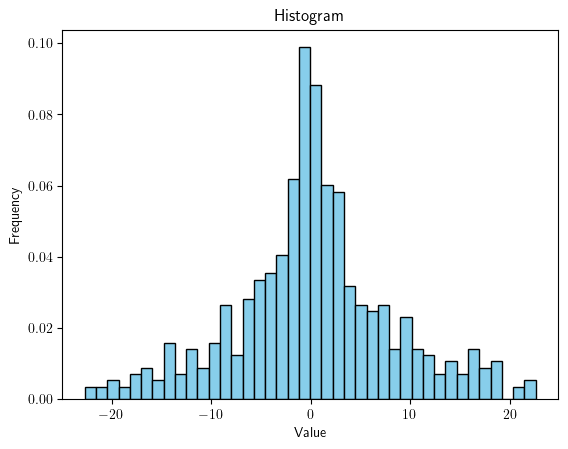

In [4]:
B = generate_uniform_points_in_ball(A,M)

# plt.hist(np.array(B[1,:]), bins=40, color='skyblue', edgecolor='black', density=True)
# plt.title('Histogram')
# plt.xlabel('Value')
# plt.ylabel('Frequency')

In [5]:
np.shape(B)

(5, 500)

In [6]:
def create_L_a(A, a):
    L_a = -np.eye(A)
    L_a[:, a] = 1
    return np.delete(L_a, a, axis=0)

In [7]:
L_matrices = [create_L_a(A, a) for a in range(A)]

In [8]:
import numpy as np
from scipy.stats import multivariate_normal

def multiv_stand_cdf(mu, Sigma, vector):
    pi = multivariate_normal(mean=mu, cov=Sigma).cdf(vector)
    return pi

In [9]:
Sigma = np.eye(A)  # Identity matrix for covariance
mu = np.zeros((A, 1))  # Zero vector for mean

In [10]:
def generate_pi_hat(A):
    pi_hat = []
    pi_true = []
    b_val = []
    for a in range(A):
        pi_hat_a = []
        pi_true_a = []
        b_val_a = []
        for m in range(M):
            mu_a_m = L_matrices[a] @  mu
            mu_a_m = np.atleast_1d(mu_a_m).flatten()
            b_a_m = L_matrices[a] @ B[:,m]
            b_a_m = np.atleast_1d(b_a_m).flatten()
            Sigma_a_m = L_matrices[a] @ Sigma @ L_matrices[a].T
            noise_a_m = np.random.normal(0, 0.05) # Adding some noise
            pi_true_a_m = multiv_stand_cdf(mu_a_m, Sigma_a_m,b_a_m)
            noisy_pi_a_m = pi_true_a_m+noise_a_m
            noisy_pi_a_m = max(0, min(1, noisy_pi_a_m))
            pi_hat_a.append(noisy_pi_a_m)
            pi_true_a.append(pi_true_a_m)
            b_val_a.append(b_a_m)
        pi_hat.append(pi_hat_a)
        pi_true.append(pi_true_a)
        b_val.append(b_val_a)

    return pi_hat, pi_true, b_val

In [11]:
num_runs = 10  # Number of repetitions
step_size = 50  # Increment of M
M_max = M  # Maximum sample size
M_min = 100  # Minimum sample size
plots = []

In [12]:
MSE_values_quantiles = []
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    MSE_values = []
    
    pi_hat, pi_true, b_val = generate_pi_hat(A)
    
    for N in range(M_min, M_max + 1, step_size):
        print(f"  Sample Size M = {N}")
        predict_A = []  # Initialize for each N
        
        # Fit regressors and collect predictions
        for a in range(A):
            pi = pi_true[a][:N]
            pi_h = pi_hat[a][:N]
            b = b_val[a][:N]
        
            # Initialize and fit the regressor
            isotonic_regressor = MultiIsotonicRegressor()
            isotonic_regressor.fit(b, pi_h)
            predict = isotonic_regressor.predict(b)
            
            predict_A.append(predict)
        
        # Convert predict_A to a NumPy array for vectorized operations
        predict_A = np.array(predict_A)  # Shape: (A, N)
        
        # Compute the cumulative sum across actions for each observation
        cumsumm = np.sum(predict_A, axis=0)  # Shape: (N,)
        
        # Prevent division by zero by replacing zeros with a small number
        cumsumm[cumsumm == 0] = 1e-8
        
        # Normalize predictions so that they sum to 1 for each observation
        normalized_predict_A = predict_A / cumsumm  # Broadcasting division
        
        # Compute MSE for each action and sum them
        MSE = 0.0
        for a in range(A):
            pi = pi_true[a][:N]
            pred = normalized_predict_A[a]
            mse = np.mean((pi-pred)**2)
            MSE += mse
        MSE_values.append(MSE)
        print(f"    MSE = {MSE:.6f}")
    
    MSE_values_quantiles.append(MSE_values)

Run 1/10
  Sample Size M = 100
    MSE = 0.007080
  Sample Size M = 150
    MSE = 0.008011
  Sample Size M = 200
    MSE = 0.007959
  Sample Size M = 250
    MSE = 0.007589
  Sample Size M = 300
    MSE = 0.007571
  Sample Size M = 350
    MSE = 0.007183
  Sample Size M = 400
    MSE = 0.007230
  Sample Size M = 450
    MSE = 0.007036
  Sample Size M = 500
    MSE = 0.006897
Run 2/10
  Sample Size M = 100
    MSE = 0.006545
  Sample Size M = 150
    MSE = 0.007121
  Sample Size M = 200
    MSE = 0.007788
  Sample Size M = 250
    MSE = 0.007355
  Sample Size M = 300
    MSE = 0.007134
  Sample Size M = 350
    MSE = 0.006930
  Sample Size M = 400
    MSE = 0.006939
  Sample Size M = 450
    MSE = 0.006790
  Sample Size M = 500
    MSE = 0.006801
Run 3/10
  Sample Size M = 100
    MSE = 0.007915
  Sample Size M = 150
    MSE = 0.007462
  Sample Size M = 200
    MSE = 0.007124
  Sample Size M = 250
    MSE = 0.006855
  Sample Size M = 300
    MSE = 0.006821
  Sample Size M = 350
    MSE 

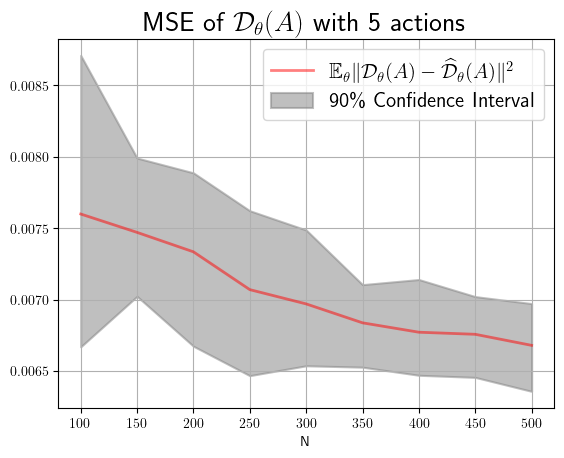

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and 90% confidence band
MSE_values_quantiles = np.array(MSE_values_quantiles)
mean_values = np.mean(MSE_values_quantiles, axis=0)
confidence_interval = np.percentile(MSE_values_quantiles, [5, 95], axis=0)
N_values = np.arange(M_min, M_max + 1, step_size)

# Plot N vs mean
plt.plot(N_values, mean_values, label=r'$\mathbb{E}_{\theta} \|\mathcal{D}_{{\theta}}(A)-\widehat{\mathcal{D}}_{{\theta}}(A)\|^2$', color='red', linewidth=2, alpha=0.5)

# Plot confidence interval
plt.fill_between(N_values, confidence_interval[0], confidence_interval[1], color='gray', alpha=0.5, linewidth=1.5, label='90\% Confidence Interval')

# Add labels and title
plt.xlabel('N')
#plt.ylabel(r'$\mathbb{E}_{\theta} \|\mathcal{D}_{{\theta}}(A)-\widehat{\mathcal{D}}_{{\theta}}(A)\|^2$')
plt.title('MSE of $\mathcal{{D}}_{{\\theta}}(A)$ with {} actions'.format(A),fontsize=20)
plt.legend(fontsize=15, markerscale=2)

plt.savefig('plots/N_vs_MSE:{}_actions.pdf'.format(A), bbox_inches='tight', dpi=300, transparent=False)
plt.grid(True)
plt.show()
